In [1]:
import os, math, random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.metrics import classification_report, confusion_matrix
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# seed고정
os.environ['PYTHONHASHSEED']=str(0)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
np.random.seed(0)
random.seed(0)
tf.random.set_seed(0)

In [2]:
# 전체 데이터셋, train, test 데이터셋 csv파일
df_shoes = pd.read_csv('/home/ubin/Project/git/df_shoes')
shoes_train = pd.read_csv('/home/ubin/Project/git/shoes_train')
shoes_test = pd.read_csv('/home/ubin/Project/git/shoes_test')

Found 1300 validated image filenames belonging to 13 classes.


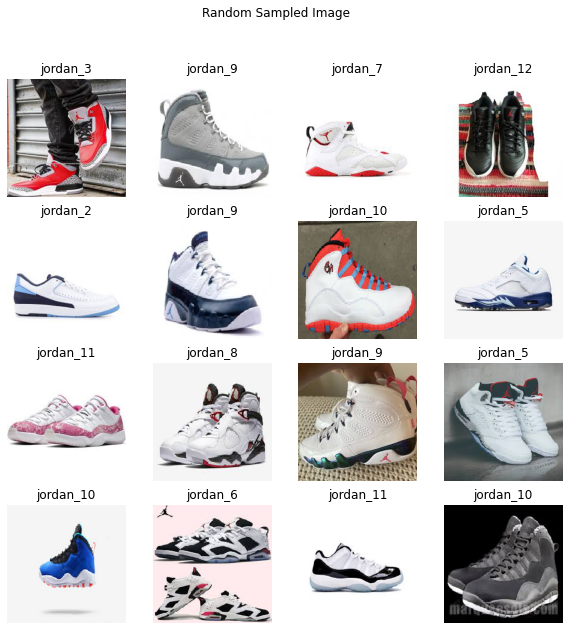

In [3]:
# 이미지와 클래스 일치하는지 체크
shoes = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    df_shoes, x_col='path', y_col='class_name', target_size=(224, 224),
    batch_size=32, shuffle=True)
plt.figure(figsize=(10, 10))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(shoes[0][0][i])
    plt.title(list(shoes.class_indices.keys())[np.argmax(shoes[0][1][i])])
    plt.axis('off')
    plt.suptitle('Random Sampled Image')

Found 1040 validated image filenames belonging to 13 classes.
Found 260 validated image filenames belonging to 13 classes.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers

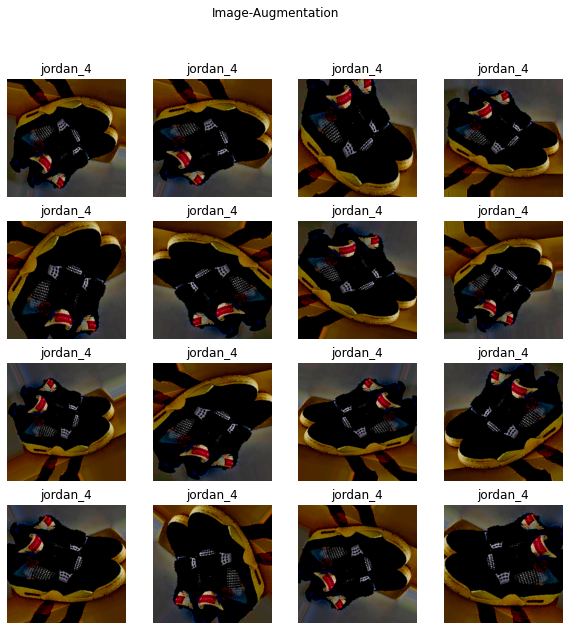

In [4]:
# 데이터 image augmentation 결과 확인
batch_size = 32
steps_per_epoch = math.ceil(shoes_train.shape[0] / batch_size)
validation_steps = math.ceil(shoes_test.shape[0] / batch_size)
train_datagen = ImageDataGenerator(
                                   rotation_range=40, 
                                   zoom_range=0.2,
                                   vertical_flip=True,
                                   horizontal_flip=True,
                                   preprocessing_function=tf.keras.applications.inception_v3.preprocess_input
                                   )
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input)
train_dataset = train_datagen.flow_from_dataframe(
    shoes_train, x_col='path', y_col='class_name', target_size=(299, 299),
    batch_size=batch_size, shuffle=True)
test_dataset = test_datagen.flow_from_dataframe(
    shoes_test, x_col='path', y_col='class_name', target_size=(299, 299),
    batch_size=batch_size, shuffle=True)
plt.figure(figsize=(10, 10))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(train_dataset[0][0][0])
    plt.title(list(train_dataset.class_indices.keys())[np.argmax(train_dataset[0][1][0])])
    plt.axis('off')
    plt.suptitle('Image-Augmentation')

In [5]:
base_model = tf.keras.applications.InceptionV3(
    include_top=False, weights='imagenet',
    input_shape=(299, 299, 3), pooling='avg')
x = base_model.output
x = Dropout(0.5)(x)
x = Dense(13, activation='softmax')(x)
model = Model(inputs = base_model.input, outputs = x)
def schedule(epoch):
    if epoch < 20:
        return .01
    if epoch < 40:
        return .005
    if epoch < 60:
        return .0025  
    if epoch < 80:
        return .00125
    else :
        return .000625
earlystopping = EarlyStopping(monitor='val_acc', min_delta = 0.01, patience = 10,restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(schedule)
model.compile(
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(
    train_dataset, steps_per_epoch=steps_per_epoch, epochs=100, workers=8,
    validation_data = test_dataset, validation_steps=validation_steps,
    callbacks=[earlystopping, lr_scheduler])

Epoch 1/100
33/33 [==============================] - 164s 5s/step - loss: 2.5859 - acc: 0.1365 - val_loss: 2.3788 - val_acc: 0.2154
Epoch 2/100
33/33 [==============================] - 12s 356ms/step - loss: 2.0197 - acc: 0.3779 - val_loss: 1.8643 - val_acc: 0.4385
Epoch 3/100
33/33 [==============================] - 12s 361ms/step - loss: 1.5044 - acc: 0.5606 - val_loss: 1.3397 - val_acc: 0.6192
Epoch 4/100
33/33 [==============================] - 12s 364ms/step - loss: 1.1253 - acc: 0.6788 - val_loss: 1.0044 - val_acc: 0.7000
Epoch 5/100
33/33 [==============================] - 12s 359ms/step - loss: 0.7988 - acc: 0.7856 - val_loss: 0.8604 - val_acc: 0.7077
Epoch 6/100
33/33 [==============================] - 12s 371ms/step - loss: 0.6161 - acc: 0.8327 - val_loss: 0.7110 - val_acc: 0.7577
Epoch 7/100
33/33 [==============================] - 12s 365ms/step - loss: 0.4462 - acc: 0.8808 - val_loss: 0.6256 - val_acc: 0.7808
Epoch 8/100
33/33 [==============================] - 12s 369ms/s

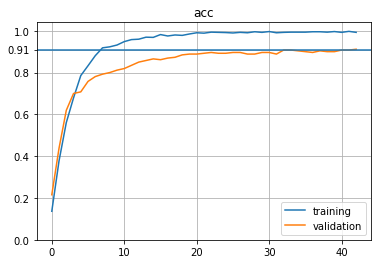

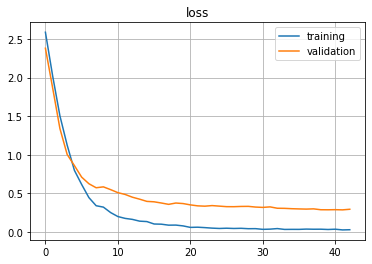

In [6]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
peak = round(np.sort(history.history['val_acc'])[-1], 2)
plt.axhline(peak)
plt.legend(['training', 'validation'])
plt.yticks((0, 0.2, 0.4, 0.6, 0.8, peak, 1), [0.0, 0.2, 0.4, 0.6, 0.8, peak, 1.0])
plt.title('acc')
plt.grid()
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.grid()
plt.title('loss')
plt.show()

In [7]:
test_dataset.reset()
y_true = []
for i in range(math.ceil(len(test_dataset.classes)/32)):
    y_true.extend(np.argmax(test_dataset[i][1], axis=1))
test_dataset.reset()
model_pred = np.argmax(model.predict(test_dataset, steps=validation_steps), axis=1)
print(confusion_matrix(y_true, model_pred))

[[19  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 1 17  1  0  0  0  0  0  0  0  0  0  1]
 [ 0  0 17  0  0  0  1  0  0  1  0  1  0]
 [ 0  0  0 18  0  1  0  0  0  0  0  1  0]
 [ 0  1  0  1 18  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 19  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 20  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0 18  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  2 18  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 17  2  0  1]
 [ 0  0  0  0  0  0  0  0  0  1 18  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 20  0]
 [ 0  0  0  2  0  0  0  0  1  0  0  0 17]]


In [8]:
equal = []
for i in range(13):
    equal.append(confusion_matrix(y_true, model_pred)[i, i])
equal = np.argsort(equal)
classname = list(test_dataset.class_indices.keys())
print('가장 못맞추는 클래스 3가지:' ,classname[equal[0]], classname[equal[1]], classname[equal[2]])
print('가장 잘맞추는 클래스 3가지:' ,classname[equal[-1]], classname[equal[-2]], classname[equal[-3]])

가장 못맞추는 클래스 3가지: jordan_10 jordan_11 jordan_6
가장 잘맞추는 클래스 3가지: jordan_8 jordan_3 jordan_2


In [9]:
print(classification_report(y_true, model_pred, target_names=list(test_dataset.class_indices.keys())))

              precision    recall  f1-score   support

    jordan_1       0.95      0.95      0.95        20
   jordan_10       0.94      0.85      0.89        20
   jordan_11       0.89      0.85      0.87        20
   jordan_12       0.86      0.90      0.88        20
   jordan_13       1.00      0.90      0.95        20
    jordan_2       0.90      0.95      0.93        20
    jordan_3       0.91      1.00      0.95        20
    jordan_4       0.90      0.90      0.90        20
    jordan_5       0.90      0.90      0.90        20
    jordan_6       0.89      0.85      0.87        20
    jordan_7       0.90      0.90      0.90        20
    jordan_8       0.87      1.00      0.93        20
    jordan_9       0.89      0.85      0.87        20

    accuracy                           0.91       260
   macro avg       0.91      0.91      0.91       260
weighted avg       0.91      0.91      0.91       260



In [10]:
# 테스트 데이터 경로
dir = '/home/ubin/Project/git/attachments'
class_path = []
cname = []
fname = []
for dirpath, class_name, filename in os.walk(dir):
    class_path.append(dirpath)
    cname.append(class_name)
    fname.append(filename)
class_path2 = []
cname2 = []
fname2 = []
for dir in class_path[1:]:
    for dirpath, class_name, filename in os.walk(dir):
        class_path2.append(dirpath)
        cname2.append(class_name)
        fname2.append(filename)
path = []
for i in range(len(class_path2)):
    for j in range(len(fname2[i])):
        path.append(os.path.join(class_path2[i], fname2[i][j]))
path = np.sort(path)

test accuracy :  0.676923076923077


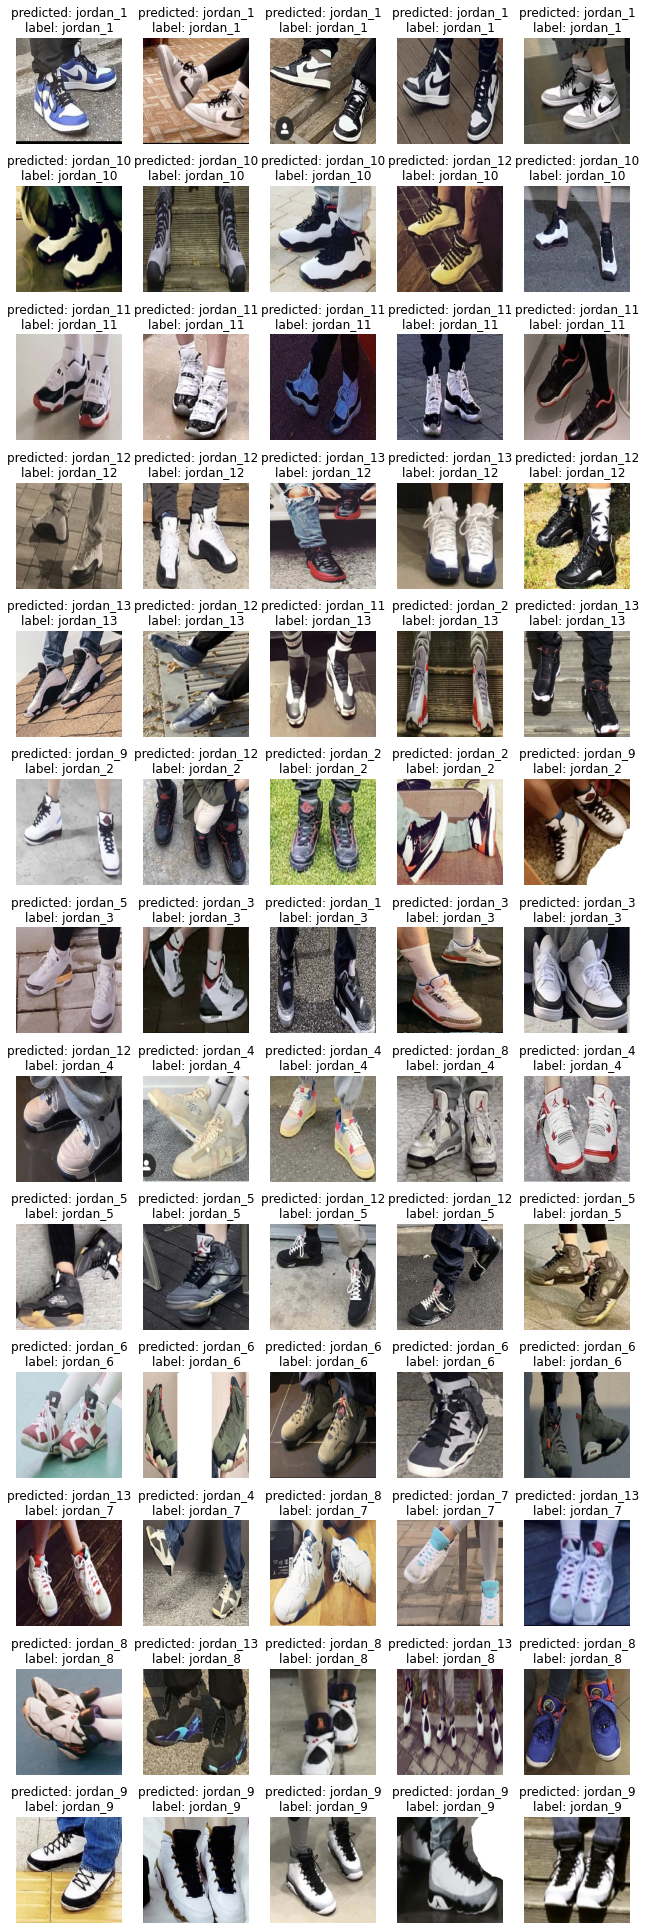

In [11]:
# 테스트 데이터 예측 결과 확인
plt.figure(figsize=(11, 35))
sum=0
for i in range(len(path)):
    img = img_to_array(load_img(path[i], target_size=(299, 299)))
    image = np.expand_dims(img, axis=0)
    img = img / 255
    image = tf.keras.applications.inception_v3.preprocess_input(image)
    ax = plt.subplot(len(path)/5, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title('predicted: ' + list(train_dataset.class_indices.keys())
    [np.argmax(model.predict(image))] + '\nlabel: ' + path[i].split('/')[-2])
    if list(train_dataset.class_indices.keys())[np.argmax(model.predict(image))] == path[i].split('/')[-2]:
        sum += 1
print('test accuracy : ', sum / len(path))